In [4]:
import sys
print(sys.executable)


C:\Users\HP\anaconda3\python.exe


In [5]:
!pip uninstall pyodbc -y


Found existing installation: pyodbc 4.0.0-unsupported
Uninstalling pyodbc-4.0.0-unsupported:
  Successfully uninstalled pyodbc-4.0.0-unsupported


In [6]:
!pip cache purge


Files removed: 2


In [7]:
!pip install pyodbc==5.1.0


In [8]:
!pip show pyodbc


Name: pyodbc
Version: 5.1.0
Summary: DB API module for ODBC
Home-page: https://github.com/mkleehammer/pyodbc
Author: 
Author-email: Michael Kleehammer <michael@kleehammer.com>
License: MIT License
Location: c:\users\hp\anaconda3\lib\site-packages
Requires: 
Required-by: 


In [1]:
pip list

Package                            Version
---------------------------------- --------------------
absl-py                            2.1.0
alabaster                          0.7.12
anaconda-client                    1.9.0
anaconda-navigator                 2.1.1
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
Babel                              2.9.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

# Start a Spark session
spark = SparkSession.builder.appName("CollaborativeFiltering").getOrCreate()

# Load the MovieLens dataset
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)

# Select relevant columns
ratings = ratings.select("userId", "movieId", "rating")

ratings.show(5)


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



In [10]:
# Split the data into training and test sets
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the ALS model with explicit feedback (default)
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

# Train the model
model = als.fit(training)


In [11]:
# Make predictions on the test data
predictions = model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 0.8743371526829706


In [12]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show(5, False)


+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                  |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{33649, 5.8601723}, {98491, 5.791086}, {5915, 5.691257}, {132333, 5.6051693}, {5490, 5.6051693}, {3358, 5.6023493}, {7096, 5.5857882}, {7078, 5.5671663}, {30803, 5.5210876}, {102217, 5.50824}]|
|2     |[{131724, 4.897637}, {1223, 4.8319244}, {1734, 4.7887087}, {174053, 4.77379}, {44761, 4.7533894}, {56145, 4.718628}, {70565, 4.71251}, {28, 4.6620927}, {59814, 4.6256785}, {5915, 4

In [13]:
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
movieRecs.show(5, False)


+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|recommendations                                                                                                                                                             |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{99, 4.803994}, {53, 4.715027}, {43, 4.5683146}, {12, 4.5273714}, {224, 4.4996295}, {250, 4.3932385}, {171, 4.382131}, {296, 4.376656}, {543, 4.3545127}, {273, 4.3381734}]|
|27     |[{243, 4.9462237}, {543, 4.545157}, {53, 4.4886136}, {337, 4.44161}, {558, 4.3400106}, {136, 4.33911}, {495, 4.337593}, {12, 4.3278813}, {276, 4.2718534}, {519, 4.229333}] |
|28     |[{53, 6.3128104}, {276, 5.6843863}, {43, 5.667121}, {543, 5.6555862}, {147, 

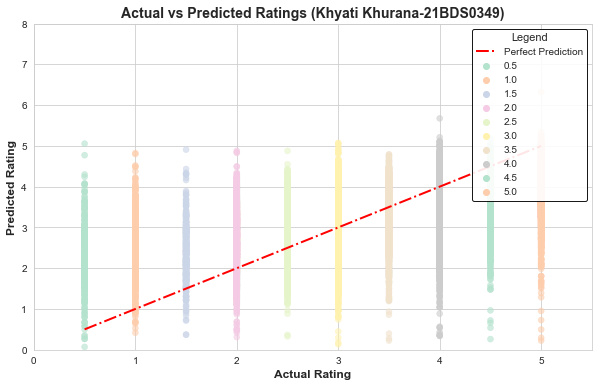

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("whitegrid")

# Convert the predictions to a Pandas DataFrame for visualization
predictions_pd = predictions.select("rating", "prediction").toPandas()

# Create the scatter plot with enhancements
plt.figure(figsize=(10, 6))

# Use a color gradient to represent density
scatter = sns.scatterplot(x=predictions_pd["rating"], y=predictions_pd["prediction"], 
                          hue=predictions_pd["rating"], palette="Pastel2", alpha=0.6, edgecolor=None)

# Add a line of perfect prediction (y = x)
plt.plot([min(predictions_pd["rating"]), max(predictions_pd["rating"])],
         [min(predictions_pd["rating"]), max(predictions_pd["rating"])],
         color="red", linewidth=2, linestyle='-.', label="Perfect Prediction")

# Set limits for better scaling
plt.xlim(0, 5.5)
plt.ylim(0, 8)

# Add grid
plt.grid(True)

# Set labels and title with bold font
plt.xlabel("Actual Rating", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Rating", fontsize=12, fontweight='bold')
plt.title("Actual vs Predicted Ratings (Khyati Khurana-21BDS0349)", fontsize=14, fontweight='bold')

# Enhance legend appearance
plt.legend(loc="upper right", fontsize=10, title='Legend', title_fontsize='11', frameon=True, framealpha=0.9, edgecolor='black')

# Show plot
plt.show()
